#**CNN + RNN model**

# Load the data

In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download -d landlord/handwriting-recognition
!unzip handwriting-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/VALIDATION_

# Import the libraries

In [3]:
import torch
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
import shutil
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, datasets
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Clean the data

In [4]:
train = pd.read_csv('written_name_train_v2.csv')
validation = pd.read_csv('written_name_validation_v2.csv')

In [5]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", validation['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [6]:
train.dropna(axis=0, inplace=True)
validation.dropna(axis=0, inplace=True)

In [7]:
train_data = train[train['IDENTITY'] != 'UNREADABLE']
valid_data = validation[validation['IDENTITY'] != 'UNREADABLE']

In [8]:
train_data['IDENTITY'] = train_data['IDENTITY'].str.upper()
valid_data['IDENTITY'] = valid_data['IDENTITY'].str.upper()

<ipython-input-8-8fe6abeeb9f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['IDENTITY'] = train_data['IDENTITY'].str.upper()
<ipython-input-8-8fe6abeeb9f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['IDENTITY'] = valid_data['IDENTITY'].str.upper()


In [9]:
train_data.reset_index(inplace = True, drop=True)
valid_data.reset_index(inplace = True, drop=True)

# Initiate Data Loader

In [10]:
class DataGenerator(Dataset):
    def __init__(self, dataframe, path, char_map, transform=None):
        self.dataframe = dataframe
        self.path = path
        self.char_map = char_map
        # self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe['FILENAME'].values[idx]
        img = cv2.imread(os.path.join(self.path, img_path), cv2.IMREAD_GRAYSCALE)
        # img = cv2.resize(img, self.img_size)
        img = img / 255.0
        if self.transform:
            img = self.transform(img)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)

        text = str(self.dataframe['IDENTITY'].values[idx])
        label = torch.tensor([self.char_map[char] for char in text], dtype=torch.long)
        return img, label

In [11]:
characters = sorted(set("".join(train['IDENTITY'].astype(str)).upper()))
char_to_label = {char: idx for idx, char in enumerate(characters)}
label_to_char = {idx: char for char, idx in char_to_label.items()}

print(char_to_label)

{' ': 0, "'": 1, '-': 2, 'A': 3, 'B': 4, 'C': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'I': 11, 'J': 12, 'K': 13, 'L': 14, 'M': 15, 'N': 16, 'O': 17, 'P': 18, 'Q': 19, 'R': 20, 'S': 21, 'T': 22, 'U': 23, 'V': 24, 'W': 25, 'X': 26, 'Y': 27, 'Z': 28, '`': 29}


In [12]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [13]:
path_train = "train_v2/train/"
path_valid = "validation_v2/validation/"

In [14]:
train_dataset = DataGenerator(train_data,path_train,char_to_label)
valid_dataset = DataGenerator(valid_data,path_valid,char_to_label)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [16]:
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(images.shape)  # This will give you the shape of the batch of images
    print(labels.shape)  # And this will give you the shape of the batch of labels
    break  # Just to demonstrate, stop after the first batch

Batch 0:
torch.Size([1, 1, 36, 388])
torch.Size([1, 10])


# Segment the images

In [28]:
def segment_words(image_tensor, label):
    """
    Given an image tensor and a label tensor, this function extracts letters from the image
    and returns a list of segmented letter images.

    Parameters
    ----------
    image_tensor : PyTorch tensor of the image to classify
    label : PyTorch tensor representing the word as a sequence of character numbers

    Returns
    -------
    list of numpy arrays: Each array represents a segmented letter image.
    """

    segmented_letters = []

    # Convert the image tensor to a NumPy array
    image = image_tensor.squeeze().numpy()
    image = (image * 255).astype('uint8')  # Assuming the tensor is normalized [0, 1]

    # Convert the image to grayscale if it's not already
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Apply threshold to binarize the image
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # Convert the label tensor to a list of integers
    label_list = label.flatten().tolist()


    # Check if the number of contours matches the length of the label
    if len(contours) == len(label_list):
        # Iterate over the contours and extract each letter as a separate image
        for i, contour in enumerate(contours):
            # Get the bounding box of the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Extract the letter
            letter_img = image[y:y+h, x:x+w]
            segmented_letters.append(letter_img)

    return segmented_letters

In [29]:
def resize_and_filter(segmented_letters, target_size=(10, 14)):
    """
    Resize segmented letter images to the target size while maintaining aspect ratio.
    Parameters
    ----------
    segmented_letters : list of PyTorch tensors
        Each tensor represents a segmented letter image.
    target_size : tuple, optional
        Target size for resizing the segmented letter images. Default is (10, 14).
    Returns
    -------
    list of PyTorch tensors: Each tensor represents a resized segmented letter image.
    """
    resized_letters = []

    for letter_img in segmented_letters:
        # Get the dimensions of the image
        height, width = letter_img.shape

        # Calculate the aspect ratio
        aspect_ratio = width / height

        # Determine new dimensions maintaining the aspect ratio
        if aspect_ratio > 1:  # Width is greater than height
            new_width = min(target_size[1], int(target_size[0] * aspect_ratio))
            new_height = min(target_size[0], int(new_width / aspect_ratio))
        else:  # Height is greater than or equal to width
            new_height = min(target_size[0], int(target_size[1] / aspect_ratio))
            new_width = min(target_size[1], int(new_height * aspect_ratio))

        # Ensure new_width and new_height are positive
        new_width = max(1, new_width)
        new_height = max(1, new_height)

        # Resize the image to new dimensions
        resized_img = cv2.resize(letter_img, (new_width, new_height), interpolation=cv2.INTER_AREA)

        # Create a blank white image of target size
        new_img = np.ones((target_size[0], target_size[1]), dtype=np.uint8) * 255

        # Calculate the offset to paste the resized image
        x_offset = (target_size[1] - new_width) // 2
        y_offset = (target_size[0] - new_height) // 2

        # Paste the resized image onto the blank white image
        new_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_img

        # Convert the cropped image back to a PyTorch tensor
        resized_tensor = torch.tensor(new_img, dtype=torch.float32)

        resized_letters.append(resized_tensor)

    return resized_letters


In [30]:
for images, labels in train_loader:
    letters = segment_words(images, labels)
    if len(letters) == 0:
        continue
    else:
        break
letters = resize_and_filter(letters)
print(letters!=0)

True


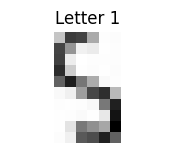

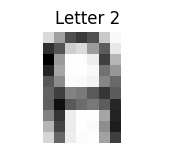

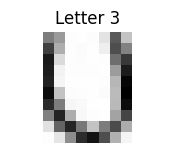

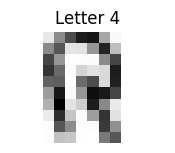

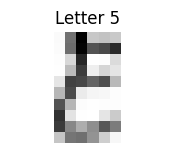

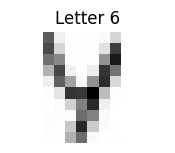

In [31]:
num_letters = len(letters)

if num_letters == 0:
    print("No letters to display.")


for i, letter_img in enumerate(letters):

    plt.figure(figsize=(2, 2))
    plt.imshow(letter_img, cmap='gray')
    plt.title(f'Letter {i+1}')
    plt.axis('off')
    plt.show()

# Load the pre-trained CNN model

In [32]:
# Define SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        """
        Entren imatges amb 1 canal de color (grayscale) i amb aquesta capa convolucional
        s'estreuen característiques loclas de la imatge detectant patrons com bordes,
        textures i altres detalls que poden ser importants.
        """
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        """
        El max pooling redueix la dimensionalitat dels mapas de característiques,
        disminuint la mida de les imatges i retenint les característiques més importants
        Això ajuda a reduir el sobreajustament i millora l'eficàcia computacional.
        """
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = nn.Dropout(0.5)
        """
        Les següents dues capes s'ecarreguen de la classificació final. Transformen
        les característiques extretes per les capas convolucionals i de pooling a les
        propietats de les diferents classes (lletres).
        """
        self.fc1 = nn.Linear(16 * 7 * 5, 64)
        self.fc2 = nn.Linear(64, 29)  # 29 perquè hi ha 29 caràcters a l'alfabet

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 7 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [33]:
# Load your trained CNN model
cnn_model = SimpleCNN()
cnn_model.load_state_dict(torch.load('simple_cnn_model.pth'))
cnn_model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=560, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=29, bias=True)
)

# Create SimpleLSTM model

In [34]:
# Define SimpleLSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [35]:
# LSTM model parameters
input_size = 29  # This should match the CNN output size
hidden_size = 64
num_layers = 1
output_size = 29  # Number of classes
lstm_model = SimpleLSTM(input_size, hidden_size, num_layers, output_size)

# Train the model

In [36]:
# Define loss and optimizer for LSTM
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.00005)

In [37]:
# Define constants
batch = 1
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [38]:
for epoch in range(num_epochs):
    # Training
    lstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Processing images"):
        optimizer.zero_grad()

        for i, l in zip(images, labels):
            # Segment images
            segmented_images = resize_and_filter(segment_words(i, l))

            if len(segmented_images) == 0:
                continue

            segmented_images_tensor = torch.stack(segmented_images)



            # Reshape the tensor with a batch size of 1
            #[batch_size, 1, embedding]
            segmented_images_tensor = segmented_images_tensor.view(segmented_images_tensor.size(0), 1, segmented_images_tensor.size(1), segmented_images_tensor.size(2))


            # CNN feature extraction
            with torch.no_grad():
                features = cnn_model(segmented_images_tensor)

            # Reshape features for LSTM
            features = features.view(-1, 1, features.size(1))

            # RNN
            outputs = lstm_model(features)

            loss = criterion(outputs, l.view(-1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += l.size(0)
            correct += (predicted == l.view(-1)).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation
    lstm_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    word_correct = 0
    word_total = 0
    letter_correct = 0
    letter_total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
          for i, l in zip(images, labels):
            segmented_images = resize_and_filter(segment_words(i, l))

            if len(segmented_images) == 0:
                continue

            segmented_images_tensor = torch.stack(segmented_images)
            segmented_images = segmented_images_tensor.view(segmented_images_tensor.size(0), 1, segmented_images_tensor.size(1), segmented_images_tensor.size(2))

            with torch.no_grad():
                features = cnn_model(segmented_images)

            features = features.view(-1, 1, features.size(1))
            outputs = lstm_model(features)
            loss = criterion(outputs, l.view(-1))

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += l.size(0)
            correct += (predicted == l.view(-1)).sum().item()
            letter_total += l.size(0)
            letter_correct += (predicted == l.view(-1)).sum().item()
            if torch.equal(predicted, l.view(-1)):
                word_correct += 1
            word_total += 1

    epoch_loss = running_loss / len(valid_loader)
    epoch_accuracy = correct / total
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    letter_accuracy = letter_correct / letter_total if letter_total > 0 else 0
    word_accuracy = word_correct / word_total if word_total > 0 else 0




    print(f"Epoch {epoch+1}/{num_epochs}, \nTrain Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, \n Test Loss: {test_losses[-1]:.4f},  Test Acc: {test_accuracies[-1]:.4f}\n")

# Save the trained model
torch.save(lstm_model.state_dict(), 'cnn_rnn_model.pth')

Processing images: 100%|██████████| 330294/330294 [06:38<00:00, 829.37it/s]


Epoch 1/10, 
Train Loss: 0.1708, Train Acc: 0.6829, 
 Test Loss: 0.1045,  Test Acc: 0.7915



Processing images: 100%|██████████| 330294/330294 [06:11<00:00, 889.85it/s]


Epoch 2/10, 
Train Loss: 0.0900, Train Acc: 0.8155, 
 Test Loss: 0.0867,  Test Acc: 0.8255



Processing images: 100%|██████████| 330294/330294 [06:20<00:00, 867.32it/s]


Epoch 3/10, 
Train Loss: 0.0795, Train Acc: 0.8357, 
 Test Loss: 0.0802,  Test Acc: 0.8367



Processing images: 100%|██████████| 330294/330294 [06:18<00:00, 872.11it/s]


Epoch 4/10, 
Train Loss: 0.0747, Train Acc: 0.8456, 
 Test Loss: 0.0755,  Test Acc: 0.8480



Processing images: 100%|██████████| 330294/330294 [06:17<00:00, 873.80it/s]


Epoch 5/10, 
Train Loss: 0.0713, Train Acc: 0.8526, 
 Test Loss: 0.0732,  Test Acc: 0.8532



Processing images: 100%|██████████| 330294/330294 [06:23<00:00, 861.57it/s]


Epoch 6/10, 
Train Loss: 0.0691, Train Acc: 0.8576, 
 Test Loss: 0.0720,  Test Acc: 0.8547



Processing images: 100%|██████████| 330294/330294 [06:26<00:00, 853.54it/s]


Epoch 7/10, 
Train Loss: 0.0676, Train Acc: 0.8604, 
 Test Loss: 0.0696,  Test Acc: 0.8614



Processing images: 100%|██████████| 330294/330294 [06:25<00:00, 856.84it/s]


Epoch 8/10, 
Train Loss: 0.0662, Train Acc: 0.8642, 
 Test Loss: 0.0692,  Test Acc: 0.8638



Processing images: 100%|██████████| 330294/330294 [06:21<00:00, 866.90it/s]


Epoch 9/10, 
Train Loss: 0.0650, Train Acc: 0.8667, 
 Test Loss: 0.0681,  Test Acc: 0.8633



Processing images: 100%|██████████| 330294/330294 [06:24<00:00, 859.41it/s]


Epoch 10/10, 
Train Loss: 0.0643, Train Acc: 0.8678, 
 Test Loss: 0.0675,  Test Acc: 0.8663



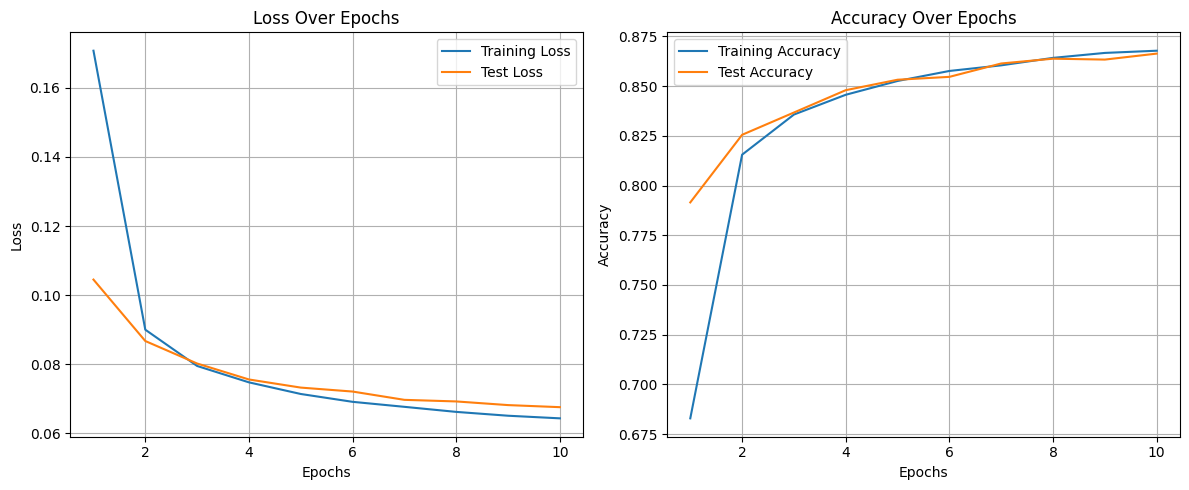

In [39]:
# Create loss and accuracy plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
# Càlcul de l'accuracy total al final de tot l'entrenament
lstm_model.eval()
correct = 0
total = 0
letter_correct = 0
letter_total = 0
word_correct = 0
word_total = 0

with torch.no_grad():
    for images, labels in valid_loader:
        for i, l in zip(images, labels):
            segmented_images = resize_and_filter(segment_words(i, l))

            if len(segmented_images) == 0:
                continue

            segmented_images_tensor = torch.stack(segmented_images)
            segmented_images_tensor = segmented_images_tensor.view(segmented_images_tensor.size(0), 1, segmented_images_tensor.size(1), segmented_images_tensor.size(2))

            with torch.no_grad():
                features = cnn_model(segmented_images_tensor)

            features = features.view(-1, 1, features.size(1))
            outputs = lstm_model(features)
            _, predicted = torch.max(outputs, 1)

            letter_total += l.size(0)
            letter_correct += (predicted == l.view(-1)).sum().item()

            if torch.equal(predicted, l.view(-1)):
                word_correct += 1
            word_total += 1  # Aquest increment ha de ser fora del if

# Calcular accuracies evitant la divisió per zero
letter_accuracy = letter_correct / letter_total if letter_total > 0 else 0
word_accuracy = word_correct / word_total if word_total > 0 else 0

print(f"Total Validation Letter Accuracy: {letter_accuracy*100:.4f}%")
print(f"Total Validation Word Accuracy: {word_accuracy*100:.4f}%")


Total Validation Letter Accuracy: 86.6349%
Total Validation Word Accuracy: 50.4375%
